In [1]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [2]:
data_dir = 'D:/00_SARDARCHITECTLABS/local data/nasa-bearing/2nd_test/2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
#     print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat((merged_data, dataset_mean_abs))

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

In [3]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


<AxesSubplot:>

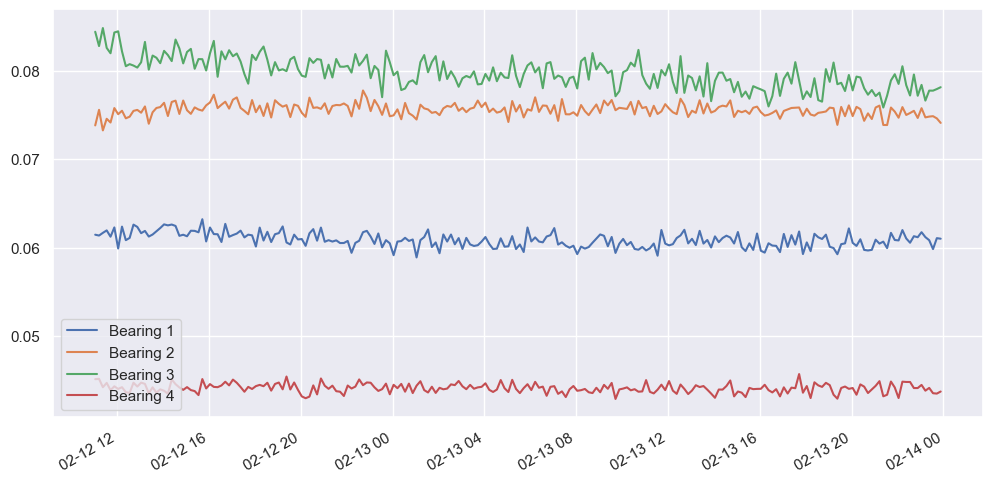

In [4]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize=(12,6))

In [5]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

<AxesSubplot:>

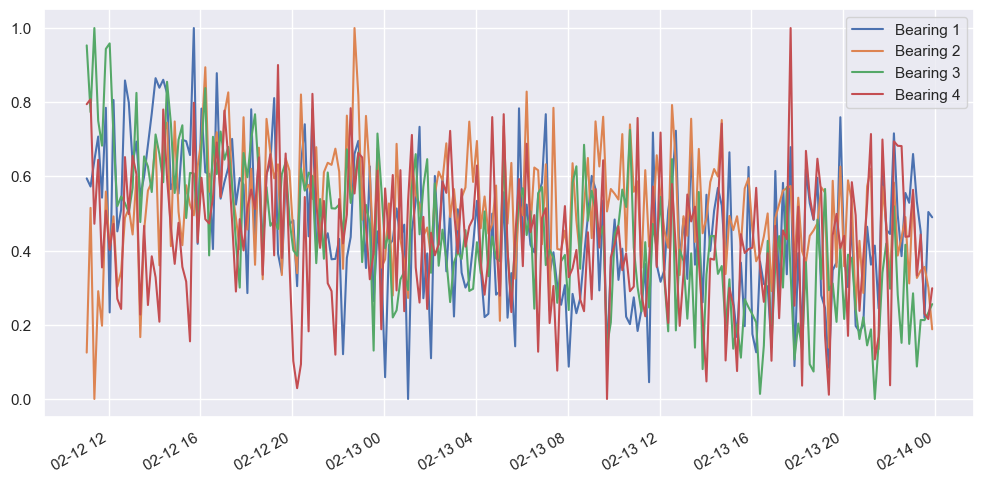

In [6]:
X_train.plot(figsize=(12,6))

# PCA

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [8]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [9]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [10]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [11]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [12]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [13]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [14]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [15]:
mean_distr = data_train.mean(axis=0)

In [16]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15.0)

<Figure size 640x480 with 0 Axes>

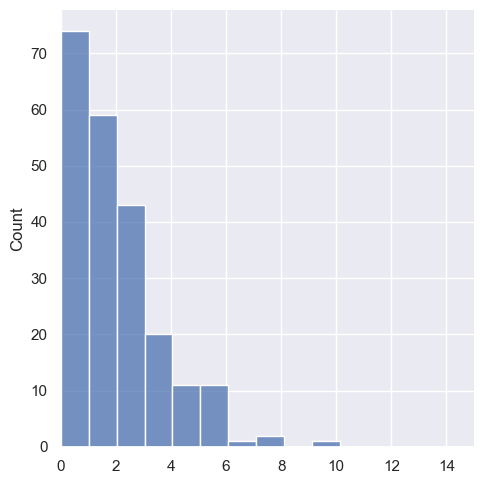

In [17]:
plt.figure()
sns.displot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 12.44444444444443, 'Mahalanobis dist')

<Figure size 640x480 with 0 Axes>

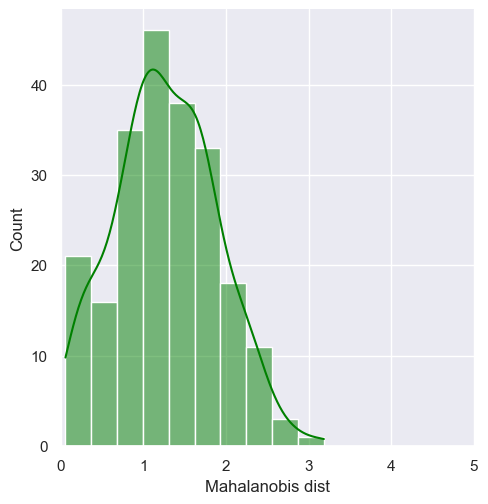

In [18]:
plt.figure()
sns.displot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [20]:
# save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()



,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.812045,False
2004-02-14 00:02:39,1.148163,3.812045,False
2004-02-14 00:12:39,1.509998,3.812045,False
2004-02-14 00:22:39,1.849725,3.812045,False
2004-02-14 00:32:39,0.701075,3.812045,False


In [21]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

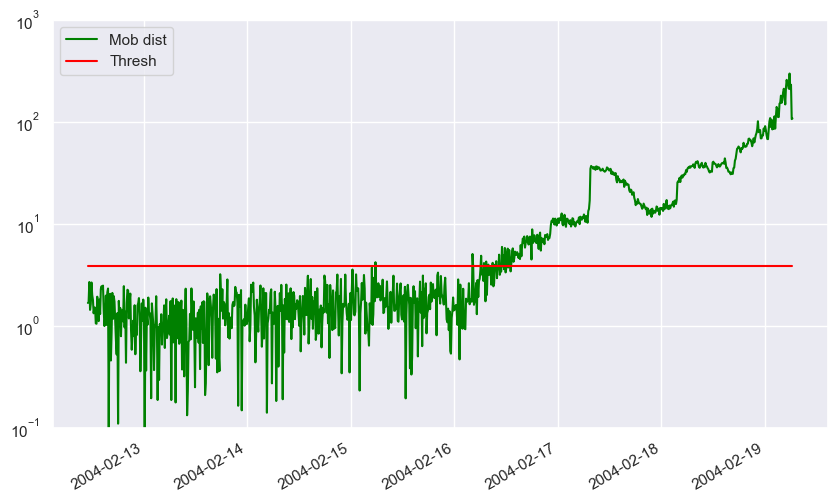

In [22]:


anomaly_alldata.plot(logy=True, figsize=(10, 6), ylim=[
                     1e-1, 1e3], color=['green', 'red'])
plt.show()



In [27]:
from tensorflow.random import set_seed 
seed(10)
set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [28]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/100
21/21 [==============================] - 1s 8ms/step - loss: 0.3626 - val_loss: 0.1733
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.2036 - val_loss: 0.1069
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1255 - val_loss: 0.0684
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0413
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0273
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0218
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0204
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0195
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0191 - val_loss: 0.0186
Epoch 10/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0179
Epoch 11/

21/21 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0087
Epoch 84/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0086
Epoch 85/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0086
Epoch 86/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0084
Epoch 87/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0086
Epoch 88/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0084
Epoch 89/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0085
Epoch 90/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0085
Epoch 91/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 92/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 93/100


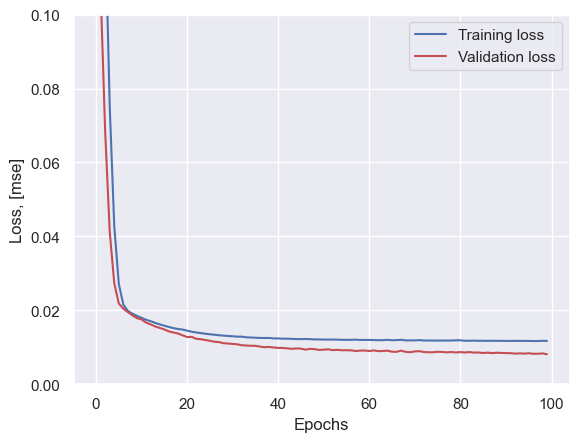

In [29]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

7/7 [==============================] - 0s 833us/step


(0.0, 0.5)

<Figure size 640x480 with 0 Axes>

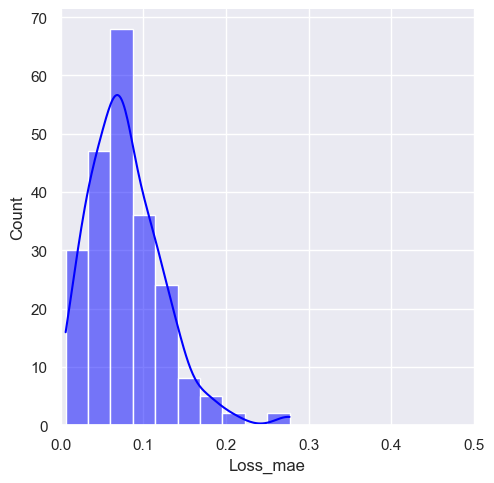

In [32]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.displot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [33]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

24/24 [==============================] - 0s 739us/step


,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.074372,0.3,False
2004-02-14 00:02:39,0.081893,0.3,False
2004-02-14 00:12:39,0.027980,0.3,False
2004-02-14 00:22:39,0.111175,0.3,False
2004-02-14 00:32:39,0.058233,0.3,False


In [35]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

7/7 [==============================] - 0s 1ms/step


<AxesSubplot:>

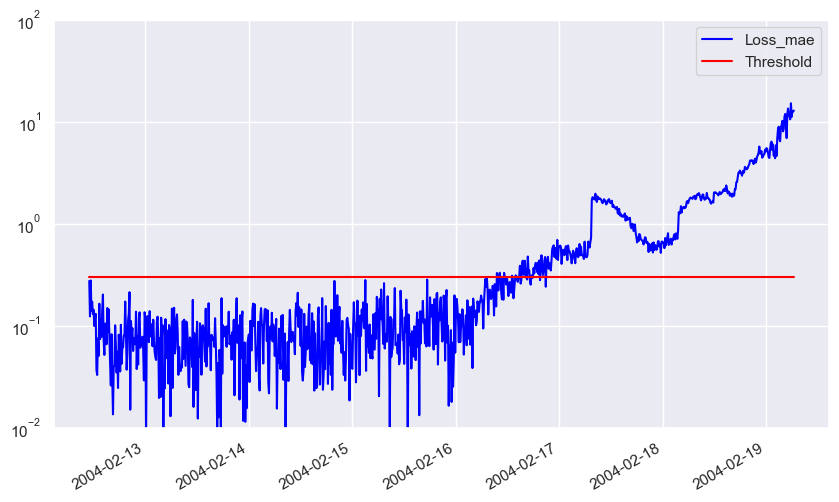

In [36]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])